# cancer_dataloading

> Helper functions etc to load cancer data. Will also install nbdev etc if in Colab (not sure yet if I need this functionality)

In [ ]:
#| default_exp cancer_dataloading

In [ ]:
#| hide

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.chdir('drive/MyDrive/cancer-proj')
    os.system('git pull')
    os.system('pip install -qU -e .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')


if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

In [ ]:
#| hide

from nbdev.showdoc import *

In [ ]:
#| export

import fastai
from fastai.vision.all import *
from base_rbt.base_model import * #probably don't need this whole thing...
from base_rbt.base_linear import show_linear_batch

In [ ]:
#| export
#colab
colab_train_dir='skin_cancer_ISIC/Train'
colab_test_dir='skin_cancer_ISIC/Test'

In [ ]:
#| export
#local
local_train_dir='/Users/hamishhaggerty/Downloads/skin_cancer_ISIC/Train'
local_test_dir='/Users/hamishhaggerty/Downloads/skin_cancer_ISIC/Test'

In [ ]:
#| hide

if on_colab:
    train_dir = colab_train_dir
    test_dir = colab_test_dir

else:
    train_dir = local_train_dir
    test_dir = local_test_dir

In [ ]:
#| export

#Seems all we need here is class_names?

def get_file_lists(train_dir):

    #train
    class_names0 = os.listdir(train_dir)
    class_names = sorted(class_names0)
    num_class = len(class_names)
    image_files = [[os.path.join(train_dir, class_name, x) 
                for x in os.listdir(os.path.join(train_dir, class_name))] 
                for class_name in class_names]

    image_file_list = []
    image_label_list = []
    for i, class_name in enumerate(class_names):
        image_file_list.extend(image_files[i])
        image_label_list.extend([i] * len(image_files[i]))
    num_total = len(image_label_list)

    return {'image_file_list':image_file_list, 'image_label_list':image_label_list, 'num_total':num_total, 'num_class':num_class, 'class_names':class_names}


In [ ]:
#| export

#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

def get_difference(x1, x2):
    return list(set(x1) - set(x2))


In [ ]:
#| export

def get_fnames_dict(train_dir,test_dir,class_names):
    "get dictionary of fnames"

        #files names
    fnames = get_image_files(train_dir)

    #Extract training set
    max_num =100 #maximum number of samples in each class
    count_dict = {i:0 for i in class_names}
    fnames_train = []
    for i in fnames:
        #st=extract_text(i.as_posix())
        st=label_func(i)
        
        if count_dict[st]<max_num: #no more than 100 samples per category
            fnames_train.append(i)
            count_dict[st]+=1
                    
    #We further partition fnames_train into a tune-valiation set
    count_dict2 = {i:0 for i in class_names}
    fnames_tune = []
    for i in fnames_train:
        st = label_func(i)
        if count_dict2[st] < 0.8*count_dict[st]:
            fnames_tune.append(i)
            count_dict2[st]+=1
            

    fnames_valid = get_difference(fnames_train,fnames_tune)

    fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

    return {'fnames':fnames,'fnames_train':fnames_train,'fnames_tune':fnames_tune,
            'fnames_valid':fnames_valid,
            'fnames_test':fnames_test
            }



In [ ]:
#| export

def get_data_dict(fnames_dict,train_dir,test_dir, #basic stuff needed
                  device,bs_val,bs=256,bs_tune=256,size=128,n_in=3 #hyperparameters
                 ):
        "get dictionary of data"

        #fnames = fnames_dict['fnames']
        fnames_train = fnames_dict['fnames_train']
        fnames_tune = fnames_dict['fnames_tune']
        fnames_valid = fnames_dict['fnames_valid']
        #fnames_test = fnames_dict['fnames_test']

        item_tfms = [Resize(size)]

        dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                        bs=bs,
                                        item_tfms=item_tfms,
                                        valid_pct=0,
                                        device=device,
                                        num_workers=12*(device=='cuda')
                                        )
        x,y = dls_train.one_batch()

        dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                        bs=bs_tune,
                                        item_tfms=item_tfms,
                                        valid_pct=0,
                                        device=device,
                                        shuffle=True,
                                        num_workers=12*(device=='cuda'),
                                        )
        xtune,ytune = dls_tune.one_batch()

        dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                        bs=bs_val,
                                        item_tfms=item_tfms,
                                        valid_pct=0,
                                        num_workers=12*(device=='cuda')
                                        )
        
        xval,yval = dls_valid.one_batch()

        vocab = dls_valid.vocab

        #return the dls etc
        return {'dls_train':dls_train,'dls_tune':dls_tune,'dls_valid':dls_valid,
                'x':x,'y':y,'xval':xval,'yval':yval,'xtune':xtune,'ytune':ytune,
                'vocab':vocab
                }


In [ ]:
#| export

def get_fnames_dls_dict(train_dir,test_dir,
                        device,bs_val,bs=256,bs_tune=256,size=128,n_in=3,
                        ):

    "Wrapper that returns a dictionary with the fnames, dls etc"

    #do stuff

    class_names = get_file_lists(train_dir)['class_names']
    
    fnames_dict = get_fnames_dict(train_dir,test_dir,class_names)

    data_dict = get_data_dict(fnames_dict,train_dir,test_dir, #basic stuff needed
                  device,bs_val,bs=256,bs_tune=256,size=128,n_in=3 #hyperparameters
                 )

    d = {**fnames_dict,**data_dict}
    
    return d



In [ ]:
#| hide

#How we want to use

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
bs=256
bs_tune=256
size=128
bs_val=174
#can define other hyperparameters here

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders and other stuff 
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

In [ ]:
#| hide

#Some simple tests

#test shapes
test_eq(x.shape[0],bs)
test_eq(xtune.shape[0],bs_tune)
test_eq(xval.shape[0],bs_val)

#test yval has same number of instances of each class each time...
if yval.shape[0] == 174:
    test_eq(yval.sum().item(),688.)

#TODO: Write tests that check that the fnames are the same every time


In [ ]:
#| export

def get_resnet_encoder(model,n_in=3):
    model = create_body(model, n_in=n_in, pretrained=False, cut=len(list(model.children()))-1)
    model.add_module('flatten', torch.nn.Flatten())
    return model

def create_model(which_model=None,ps=8192,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder

In [ ]:
#| hide

#test

ps=8192
device=device=default_device().type
cuda=(device=='cuda')

model,encoder = create_model(which_model='bt_pretrain')
for p in model.parameters():
    test_eq(p.requires_grad,True)

#| hide

def sum_params(model):

    s=0
    for p in model.parameters():
        s+=p.sum()
    return s.item()


def colab_tests(): #we run out of memory locally with these

    #Test that shape of encoder is 2048
    _,e = create_model(which_model='bt_pretrain')
    test_eq(e(x).shape[1],2048) 

    #Test that pretrained models (encoders) have the same weights (roughyl) each time
    _,e = create_model(which_model='bt_pretrain')
    test_eq((sum_params(e)-175864.4062)<0.001,True)

    _,e = create_model(which_model='supervised_pretrain')
    test_eq((sum_params(e)-39438.5078125)<0.001,True)

    #Test that non-pretrained model has diff (i.e. random) weights each time
    _,e1 = create_model(which_model='no_pretrain')
    _,e2 = create_model(which_model='no_pretrain')
    test_ne(sum_params(e1),sum_params(e2))



if on_colab:
    colab_tests()

Using cache found in /Users/hamishhaggerty/.cache/torch/hub/facebookresearch_barlowtwins_main
/Users/hamishhaggerty/opt/anaconda3/envs/renamelater/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hamishhaggerty/opt/anaconda3/envs/renamelater/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#| export

BYOL_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1
                )


TUNE_Augs=dict(blur_r = BYOL_Augs['blur_r'],blur_s = BYOL_Augs['blur_s'], flip_p=0.25,
                rotate_p=0.25,jitter_p=0.0,bw_p=0.0,blur_p=0.0,resize_scale=(0.7, 1.0),
                resize_ratio=(3/4, 4/3),rotate_deg=45.0
                )

Val_Augs = dict(TUNE_Augs)


def create_aug_pipelines(size,device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs):
    "Create the BT pipelines, the tune and val pipelines"

    aug_dict = {}

    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'], #prob of performing aug
                        same_on_batch=False,stats=None, cuda=(device=='cuda'))

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'], #prob of performing aug
                        same_on_batch=False,stats=None, cuda=(device=='cuda'))

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]


    aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=TUNE_Augs['resize_scale'],resize_ratio=TUNE_Augs['resize_ratio'],noise_std=None,
                    blur_r=TUNE_Augs['blur_r'],blur_s=TUNE_Augs['blur_s'], rotate_deg=TUNE_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=TUNE_Augs['flip_p'], rotate_p=TUNE_Augs['rotate_p'],noise_p=0.0, jitter_p=TUNE_Augs['jitter_p'],
                    bw_p=TUNE_Augs['bw_p'], blur_p=TUNE_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))]#,P=0.0)




    aug_pipelines_test =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=Val_Augs['resize_scale'],resize_ratio=Val_Augs['resize_ratio'],noise_std=None,
                    blur_r=Val_Augs['blur_r'],blur_s=Val_Augs['blur_s'], rotate_deg=Val_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=Val_Augs['flip_p'], rotate_p=Val_Augs['rotate_p'],noise_p=0.0, jitter_p=Val_Augs['jitter_p'],
                    bw_p=Val_Augs['bw_p'], blur_p=Val_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))]#,P=0.0)

    aug_dict['aug_pipelines'] = aug_pipelines
    aug_dict['aug_pipelines_tune'] = aug_pipelines_tune
    aug_dict['aug_pipelines_test'] = aug_pipelines_test

    return aug_dict



In [ ]:
#| hide
device='cpu'
aug_dict = create_aug_pipelines(size=128,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


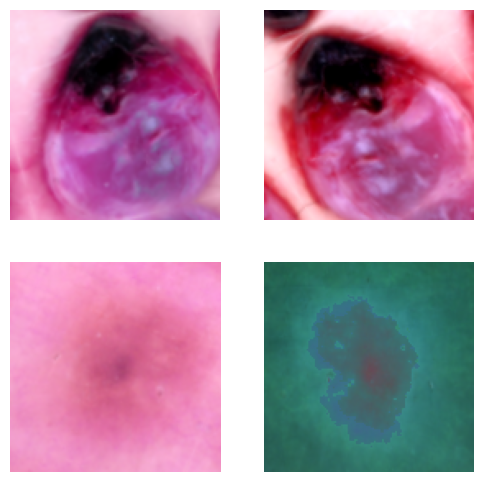

In [ ]:
#| hide

show_bt_batch(dls=dls_train,n_in=3,aug=aug_dict['aug_pipelines'],n=2,print_augs=True)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


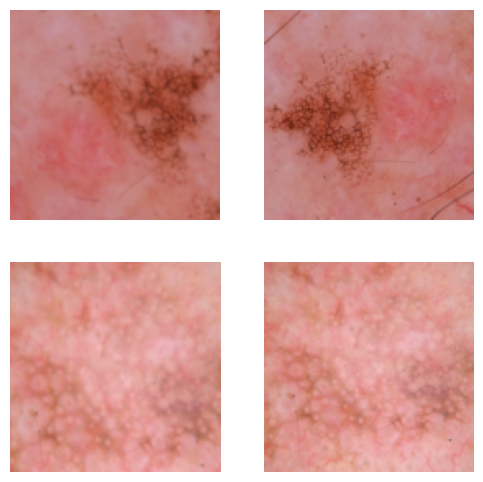

In [ ]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_dict['aug_pipelines_tune'],n=2,print_augs=True)

In [ ]:
#| hide

#test: We copy paste the BYOL augs we have been using (which we know give good performance)

#########################
flip_p1 = 0.5
flip_p2 = 0.5

##byol defaults
jitter_p1 = 0.8
jitter_p2 = 0.8

#byol defaults
bw_p1 = 0.2
bw_p2 = 0.2

# bw_p1 = 0.0
# bw_p2 = 0.0

blur_p1 = 1.0
blur_p2 = 0.1

sol_p1 = 0.0
sol_p2 = 0.2 #BYOL default
#sol_p2 = 0.0

noise_p1 = 0.0
noise_p2 = 0.0
#Noise isn't included! So we exclude for now

#Normalization?? None for now as it looks weird

resize_scale=(0.7, 1.0)
resize_ratio=(3/4, 4/3)

#Rotation isn't included in ImageNet. We just include some. 
rotate_deg = 45
rotate_p = 0.5

##Values of hps:
blur_r = (0.1,2) #like BYOL
blur_s = 13 #as ~ 128/10 like BYOL

#blur_r = (0.1,4) #like BYOL
#blur_s = 13 #as ~ 128/10 like BYOL


sol_t = 0.1 #kornia defaults. Not sure still about BYOL defaults.
sol_a = 0.1

noise_std = 0.1 

###################

###################


for k in BYOL_Augs.keys():
    test_eq(BYOL_Augs[k],locals()[k])

#Hyperparams for fine-tuning augmentations. We use: blur; jitter; grayscale (maybe) and soft augs.
blur_r = blur_r
blur_s = blur_s
flip_p = 0.25
rotate_p = 0.25
jitter_p = 0.0
bw_p = 0.0
blur_p = 0.0
#########################

for k in TUNE_Augs.keys():

    test_eq(TUNE_Augs[k],locals()[k])



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()